In [2]:
# Importing the necessary Libraries
import numpy as np # linear algebra
import pandas as pd # data processing
import scipy as sp
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Standard plotly imports
#import plotly.plotly as py
import plotly.graph_objs as go
import plotly.tools as tls
from plotly.offline import iplot, init_notebook_mode
#import cufflinks
#import cufflinks as cf
import plotly.figure_factory as ff

# Using plotly + cufflinks in offline mode
init_notebook_mode(connected=True)
#cufflinks.go_offline(connected=True)

In [4]:
# Preprocessing, modelling and evaluating
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold
from xgboost import XGBClassifier
import xgboost as xgb

In [7]:
## Hyperopt modules
#from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK, STATUS_RUNNING
#from functools import partial

import os
import gc
os.chdir("C:/My Portfolio/Data_Fraud Detection")
print(os.listdir("C:/My Portfolio/Data_Fraud Detection"))

['sample_submission.csv', 'test_identity.csv', 'test_transaction.csv', 'train_identity.csv', 'train_transaction.csv']


In [15]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [8]:
df_id = pd.read_csv("C:/My Portfolio/Data_Fraud Detection/train_identity.csv")
df_trans = pd.read_csv("C:/My Portfolio/Data_Fraud Detection/train_transaction.csv")

In [9]:
def resumetable(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    summary['Third Value'] = df.loc[2].values

    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2),2)

    return summary

## Function to reduce the DF size
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

def CalcOutliers(df_num):

    # calculating mean and std of the array
    data_mean, data_std = np.mean(df_num), np.std(df_num)

    # seting the cut line to both higher and lower values
    # You can change this value
    cut = data_std * 3

    #Calculating the higher and lower cut values
    lower, upper = data_mean - cut, data_mean + cut

    # creating an array of lower, higher and total outlier values
    outliers_lower = [x for x in df_num if x < lower]
    outliers_higher = [x for x in df_num if x > upper]
    outliers_total = [x for x in df_num if x < lower or x > upper]

    # array without outlier values
    outliers_removed = [x for x in df_num if x > lower and x < upper]

    print('Identified lowest outliers: %d' % len(outliers_lower)) # printing total number of values in lower cut of outliers
    print('Identified upper outliers: %d' % len(outliers_higher)) # printing total number of values in higher cut of outliers
    print('Total outlier observations: %d' % len(outliers_total)) # printing total number of values outliers of both sides
    print('Non-outlier observations: %d' % len(outliers_removed)) # printing total number of non outlier values
    print("Total percentual of Outliers: ", round((len(outliers_total) / len(outliers_removed) )*100, 4)) # Percentual of outliers in points

    return

In [10]:
## REducing memory
df_trans = reduce_mem_usage(df_trans)
df_id = reduce_mem_usage(df_id)

Mem. usage decreased to 542.35 Mb (69.4% reduction)
Mem. usage decreased to 25.86 Mb (42.7% reduction)


In [11]:
#Summary of the transaction table
resumetable(df_trans)[:25]

Dataset Shape: (590540, 394)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,TransactionID,int32,0,590540,2987000,2987001,2987002,19.17
1,isFraud,int8,0,2,0,0,0,0.22
2,TransactionDT,int32,0,573349,86400,86401,86469,19.11
3,TransactionAmt,float16,0,8195,68.5,29.0,59.0,8.10
4,ProductCD,object,0,5,W,W,W,1.28
5,card1,int16,0,13553,13926,2755,4663,9.97
6,card2,float16,8933,500,NaN,404.0,490.0,6.32
7,card3,float16,1565,114,150.0,150.0,150.0,0.68
8,card4,object,1577,4,discover,mastercard,visa,1.09
9,card5,float16,4259,119,142.0,102.0,166.0,2.66


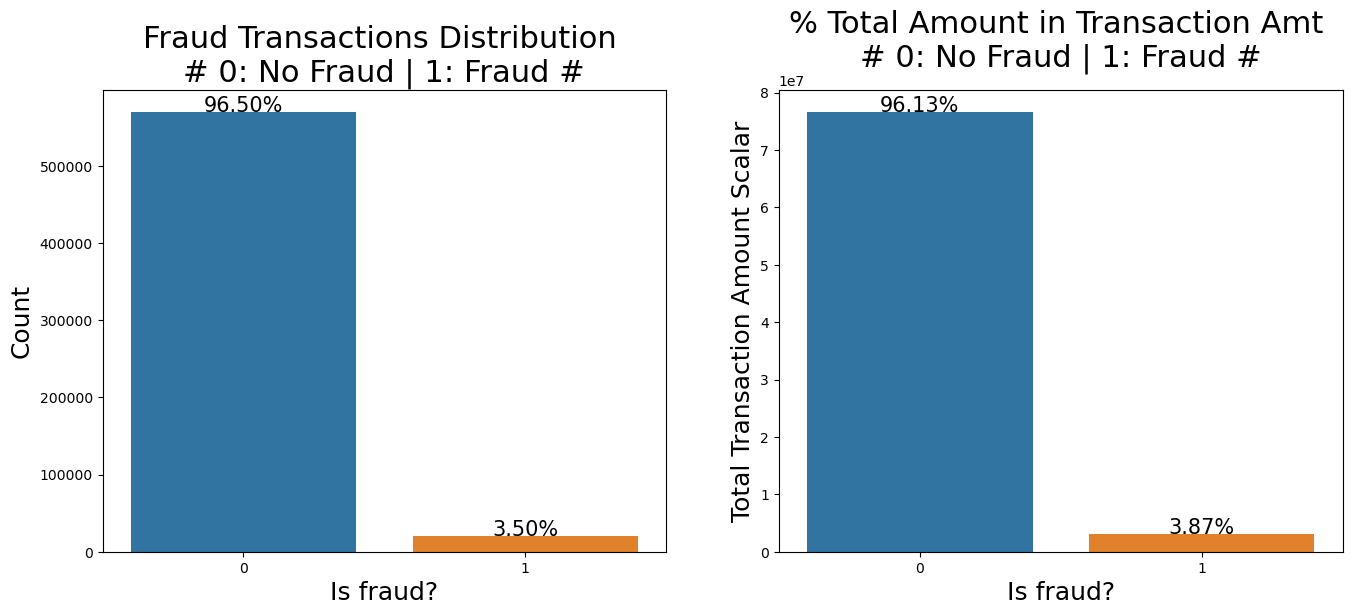

In [21]:
#Converting TransactionAmt to float data type
df_trans['TransactionAmt'] = df_trans['TransactionAmt'].astype(float)
total = len(df_trans)

#calculating the total number of rows and the total amount involved in the transactions by grouping the DataFrame based on the "isFraud" column and summing up the "TransactionAmt" column
total_amt = df_trans.groupby(['isFraud'])['TransactionAmt'].sum().sum()
plt.figure(figsize=(16,6))

#bar chart using the Seaborn library to visualize the distribution of fraud and non-fraud transactions based on the "isFraud" column
plt.subplot(121)
g = sns.countplot(x='isFraud', data=df_trans, )
g.set_title("Fraud Transactions Distribution \n# 0: No Fraud | 1: Fraud #", fontsize=22)
g.set_xlabel("Is fraud?", fontsize=18)
g.set_ylabel('Count', fontsize=18)
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=15)

#bar chart to show the percentage of the total amount involved in each type of transaction
perc_amt = (df_trans.groupby(['isFraud'])['TransactionAmt'].sum())
perc_amt = perc_amt.reset_index()
plt.subplot(122)
g1 = sns.barplot(x='isFraud', y='TransactionAmt',  dodge=True, data=perc_amt)
g1.set_title("% Total Amount in Transaction Amt \n# 0: No Fraud | 1: Fraud #", fontsize=22)
g1.set_xlabel("Is fraud?", fontsize=18)
g1.set_ylabel('Total Transaction Amount Scalar', fontsize=18)
for p in g1.patches:
    height = p.get_height()
    g1.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total_amt * 100),
            ha="center", fontsize=15)

plt.show()

In [13]:
#finding quantiles of TransactionAmt
df_trans['TransactionAmt'] = df_trans['TransactionAmt'].astype(float)
print("Transaction Amounts Quantiles:")
print(df_trans['TransactionAmt'].quantile([.01, .025, .1, .25, .5, .75, .9, .975, .99]))

Transaction Amounts Quantiles:
0.010       9.242188
0.025      14.500000
0.100      25.953125
0.250      43.312500
0.500      68.750000
0.750     125.000000
0.900     275.250000
0.975     648.262500
0.990    1104.000000
Name: TransactionAmt, dtype: float64


C:\Users\yashn\AppData\Local\Temp\ipykernel_12520\2587815640.py:6: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


C:\Users\yashn\AppData\Local\Temp\ipykernel_12520\2587815640.py:13: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




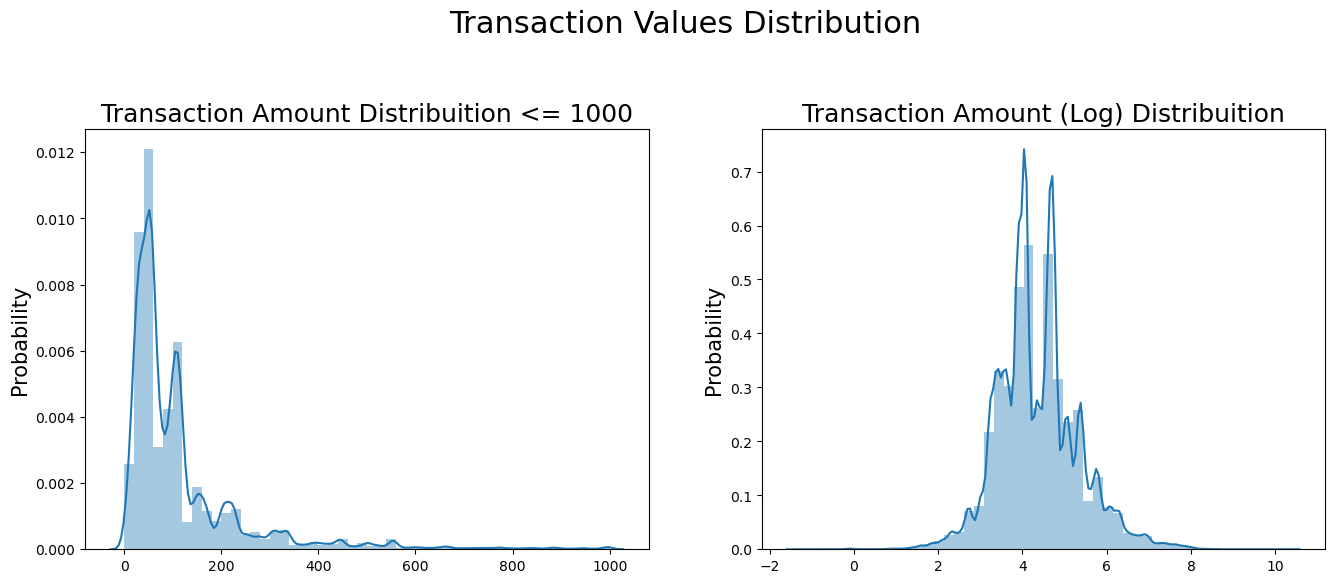

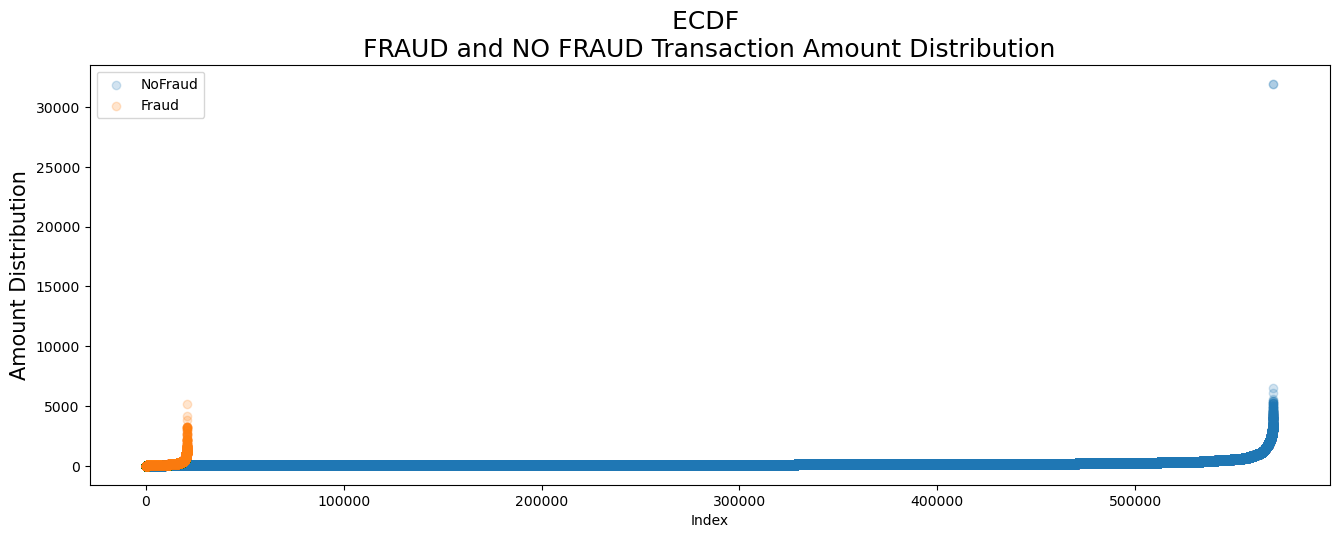

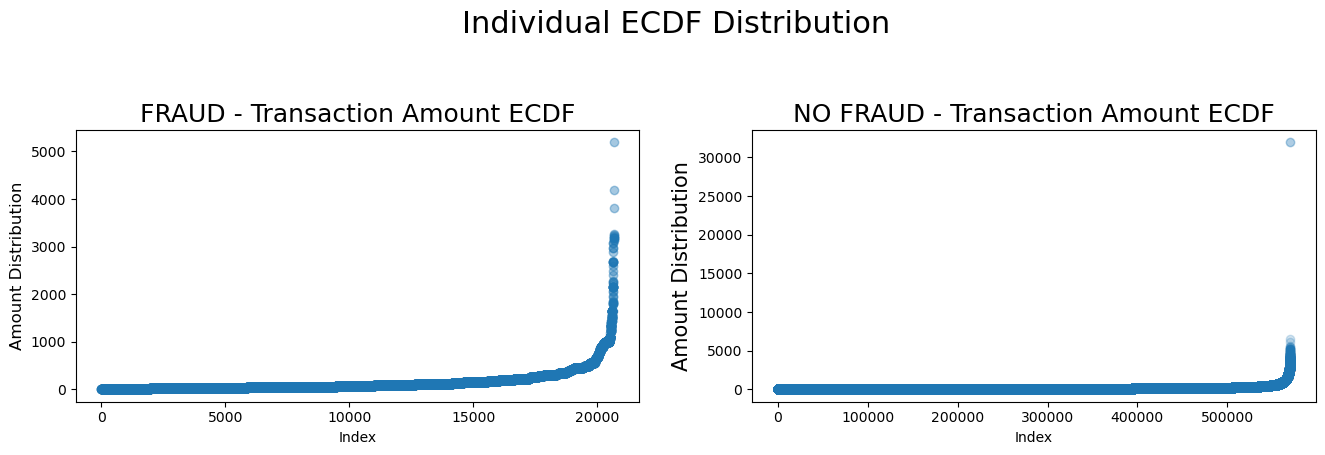

In [22]:
plt.figure(figsize=(16,12))

#plot to see distribution for transactions with a value less than or equal to 1000
plt.suptitle('Transaction Values Distribution', fontsize=22)
plt.subplot(221)
g = sns.distplot(df_trans[df_trans['TransactionAmt'] <= 1000]['TransactionAmt'])
g.set_title("Transaction Amount Distribuition <= 1000", fontsize=18)
g.set_xlabel("")
g.set_ylabel("Probability", fontsize=15)

#plot to see logarithm of the transaction amounts
plt.subplot(222)
g1 = sns.distplot(np.log(df_trans['TransactionAmt']))
g1.set_title("Transaction Amount (Log) Distribuition", fontsize=18)
g1.set_xlabel("")
g1.set_ylabel("Probability", fontsize=15)

plt.figure(figsize=(16,12))

#Scatter plot to show show the empirical cumulative distribution function (ECDF) of the transaction amounts for both fraud and non-fraud transactions
plt.subplot(212)
g4 = plt.scatter(range(df_trans[df_trans['isFraud'] == 0].shape[0]),
                 np.sort(df_trans[df_trans['isFraud'] == 0]['TransactionAmt'].values),
                 label='NoFraud', alpha=.2)
g4 = plt.scatter(range(df_trans[df_trans['isFraud'] == 1].shape[0]),
                 np.sort(df_trans[df_trans['isFraud'] == 1]['TransactionAmt'].values),
                 label='Fraud', alpha=.2)
g4= plt.title("ECDF \nFRAUD and NO FRAUD Transaction Amount Distribution", fontsize=18)
g4 = plt.xlabel("Index")
g4 = plt.ylabel("Amount Distribution", fontsize=15)
g4 = plt.legend()

plt.figure(figsize=(16,12))

# plot to show ECDF of transaction amounts for Fraud transactions
plt.subplot(321)
g = plt.scatter(range(df_trans[df_trans['isFraud'] == 1].shape[0]),
                 np.sort(df_trans[df_trans['isFraud'] == 1]['TransactionAmt'].values),
                label='isFraud', alpha=.4)
plt.title("FRAUD - Transaction Amount ECDF", fontsize=18)
plt.xlabel("Index")
plt.ylabel("Amount Distribution", fontsize=12)

# plot to show ECDF of transaction amounts for non-Fraud transactions
plt.subplot(322)
g1 = plt.scatter(range(df_trans[df_trans['isFraud'] == 0].shape[0]),
                 np.sort(df_trans[df_trans['isFraud'] == 0]['TransactionAmt'].values),
                 label='NoFraud', alpha=.2)
g1= plt.title("NO FRAUD - Transaction Amount ECDF", fontsize=18)
g1 = plt.xlabel("Index")
g1 = plt.ylabel("Amount Distribution", fontsize=15)

plt.suptitle('Individual ECDF Distribution', fontsize=22)

plt.show()

In [19]:
#Quantiles of Fraud and non-Fraud Transactions
print(pd.concat([df_trans[df_trans['isFraud'] == 1]['TransactionAmt']\
                 .quantile([.01, .1, .25, .5, .75, .9, .99])\
                 .reset_index(),
                 df_trans[df_trans['isFraud'] == 0]['TransactionAmt']\
                 .quantile([.01, .1, .25, .5, .75, .9, .99])\
                 .reset_index()],
                axis=1, keys=['Fraud', "No Fraud"]))

  Fraud                No Fraud               
  index TransactionAmt    index TransactionAmt
0  0.01       6.739453     0.01       9.511875
1  0.10      18.937500     0.10      26.312500
2  0.25      35.031250     0.25      43.968750
3  0.50      75.000000     0.50      68.500000
4  0.75     161.000000     0.75     120.000000
5  0.90     335.000000     0.90     267.100000
6  0.99     994.000000     0.99    1104.000000


In [20]:
#finding TransactionAmt Outliers
CalcOutliers(df_trans['TransactionAmt'])

Identified lowest outliers: 0
Identified upper outliers: 10097
Total outlier observations: 10097
Non-outlier observations: 580443
Total percentual of Outliers:  1.7395


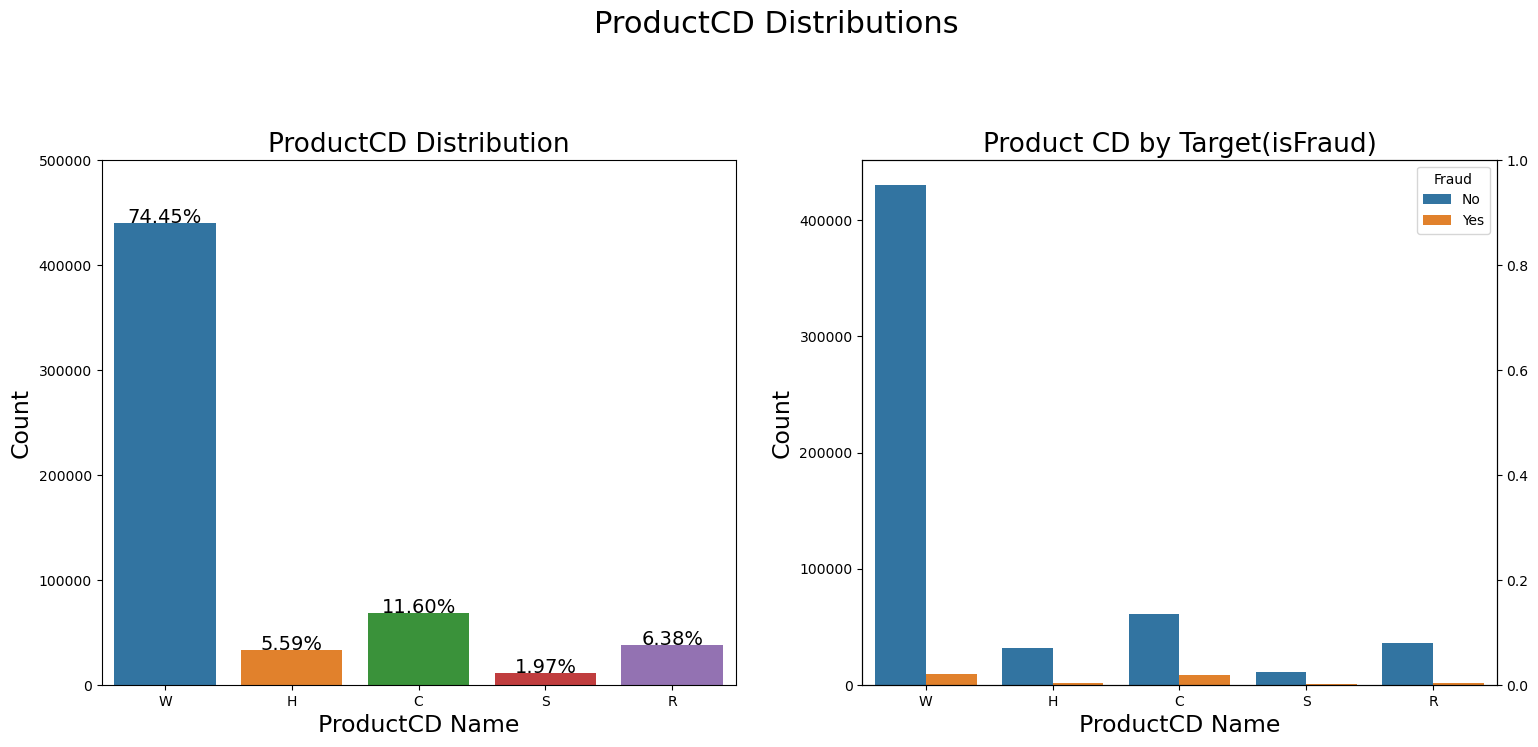

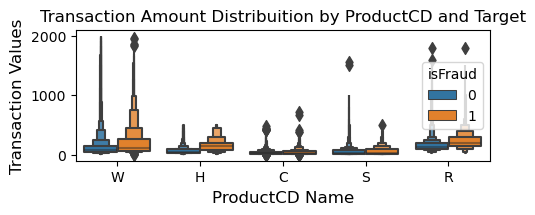

In [31]:
#Creating temporary table which stores the proportion of Fraud and non-Fraud transactions by product code
tmp = pd.crosstab(df_trans['ProductCD'], df_trans['isFraud'], normalize='index') * 100
tmp = tmp.reset_index()
tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

plt.figure(figsize=(18,15))
plt.suptitle('ProductCD Distributions', fontsize=22)

#Count plot of the distribution of product codes in the dataset
#The height of each bar represents the count of transactions with that product code
plt.subplot(221)
g = sns.countplot(x='ProductCD', data=df_trans)
# plt.legend(title='Fraud', loc='upper center', labels=['No', 'Yes'])

g.set_title("ProductCD Distribution", fontsize=19)
g.set_xlabel("ProductCD Name", fontsize=17)
g.set_ylabel("Count", fontsize=17)
g.set_ylim(0,500000)
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=14)

#plt.subplot(222)
"""
g1 = sns.countplot(x='ProductCD', hue='isFraud', data=df_trans)
plt.legend(title='Fraud', loc='best', labels=['No', 'Yes'])
gt = g1.twinx()
gt = sns.pointplot(x='ProductCD', y='Fraud', data=tmp, color='black', order=['W', 'H',"C", "S", "R"], legend=False)
gt.set_ylabel("% of Fraud Transactions", fontsize=16)

g1.set_title("Product CD by Target(isFraud)", fontsize=19)
g1.set_xlabel("ProductCD Name", fontsize=17)
g1.set_ylabel("Count", fontsize=17)
"""

#Breakdown of the above plot, where the bars are now split by whether the transaction was Fraud or not
plt.subplot(222)
g1 = sns.countplot(x='ProductCD', hue='isFraud', data=df_trans)
plt.legend(title='Fraud', loc='best', labels=['No', 'Yes'])
gt = g1.twinx()
tmp_melt = pd.melt(tmp, id_vars='ProductCD', value_vars=['NoFraud', 'Fraud'], var_name='isFraud', value_name='Percentage')
gt = sns.catplot(x='ProductCD', y='Percentage', hue='isFraud', data=tmp_melt, kind='point', order=['W', 'H',"C", "S", "R"], legend=False)
gt.set_ylabels("% of Fraud Transactions", fontsize=16)

g1.set_title("Product CD by Target(isFraud)", fontsize=19)
g1.set_xlabel("ProductCD Name", fontsize=17)
g1.set_ylabel("Count", fontsize=17)


#Boxenplot of transaction values, split by product code and whether the transaction was Fraud or not
plt.subplot(212)
g3 = sns.boxenplot(x='ProductCD', y='TransactionAmt', hue='isFraud',
              data=df_trans[df_trans['TransactionAmt'] <= 2000] )
g3.set_title("Transaction Amount Distribuition by ProductCD and Target", fontsize=12)
g3.set_xlabel("ProductCD Name", fontsize=12)
g3.set_ylabel("Transaction Values", fontsize=12)

plt.subplots_adjust(hspace = 0.8, top = 0.85)

plt.show()

In [32]:
# From the above graphs we can see that W, C and R are the most frequent values
# In W, H and R the distribution of Fraud values are slightly higher than the Non-Fraud Transactions

In [33]:
#Now, let's explore the card features(categorical with 6 columns of which 4 are numerical)
# Understanding the distribution of values | transactions vs % of Fraud for each values

In [34]:
resumetable(df_trans[['card1', 'card2', 'card3','card4', 'card5', 'card6']])

Dataset Shape: (590540, 6)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,card1,int16,0,13553,13926,2755,4663,9.97
1,card2,float16,8933,500,NaN,404.0,490.0,6.32
2,card3,float16,1565,114,150.0,150.0,150.0,0.68
3,card4,object,1577,4,discover,mastercard,visa,1.09
4,card5,float16,4259,119,142.0,102.0,166.0,2.66
5,card6,object,1571,4,credit,credit,debit,0.82


In [35]:
print("Card Features Quantiles: ")
print(df_trans[['card1', 'card2', 'card3', 'card5']].quantile([0.01, .025, .1, .25, .5, .75, .975, .99]))

Card Features Quantiles: 
         card1  card2  card3  card5
0.010   1338.0  100.0  144.0  102.0
0.025   1675.0  111.0  150.0  102.0
0.100   2803.0  111.0  150.0  126.0
0.250   6019.0  214.0  150.0  166.0
0.500   9678.0  361.0  150.0  226.0
0.750  14184.0  512.0  150.0  226.0
0.975  18018.0  583.0  185.0  226.0
0.990  18238.0  583.0  185.0  226.0


In [36]:
#Card 1 and Card 2 has a large distribution of values

In [39]:
#grouping infrequent values in the columns card3 and card5 under a single label "Others" to reduce the number of unique values in the dataset
#helps improve model performance and reduce noise in the data.
df_trans.loc[df_trans.card3.isin(df_trans.card3.value_counts()[df_trans.card3.value_counts() < 200].index), 'card3'] = "Others"
df_trans.loc[df_trans.card5.isin(df_trans.card5.value_counts()[df_trans.card5.value_counts() < 300].index), 'card5'] = "Others"

C:\Users\yashn\AppData\Local\Temp\ipykernel_12520\1535791673.py:13: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


C:\Users\yashn\AppData\Local\Temp\ipykernel_12520\1535791673.py:14: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


C:\Users\yashn\AppData\Local\Temp\ipykernel_12520\1535791673.py:21: UserWarning:



`distplot`

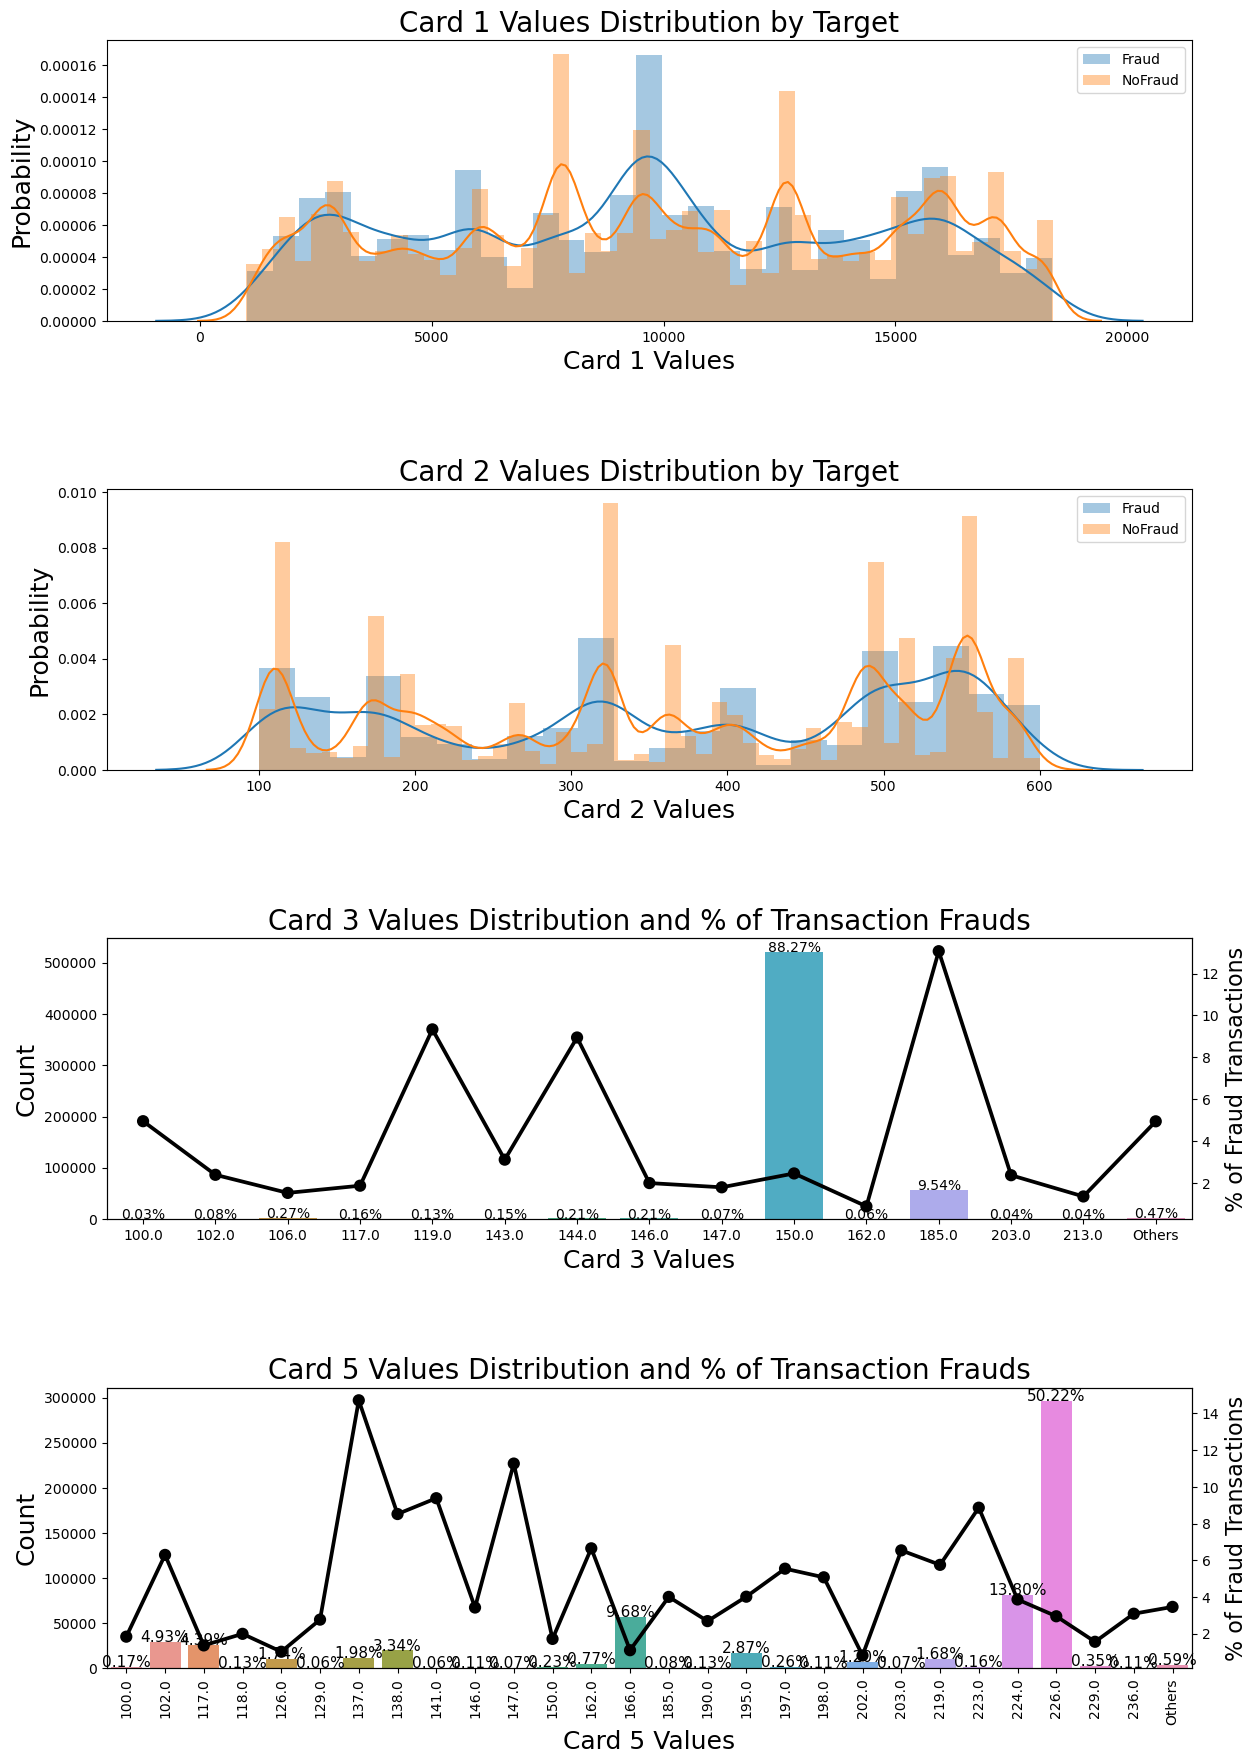

In [40]:
#Visualizing Card1, Card2, Card3, Card5 Distributions
#Creating temporary table which stores the proportion of Fraud and non-Fraud transactions for Card3 values
tmp = pd.crosstab(df_trans['card3'], df_trans['isFraud'], normalize='index') * 100
tmp = tmp.reset_index()
tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

#Creating temporary table which stores the proportion of Fraud and non-Fraud transactions for Card3 values
tmp2 = pd.crosstab(df_trans['card5'], df_trans['isFraud'], normalize='index') * 100
tmp2 = tmp2.reset_index()
tmp2.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

plt.figure(figsize=(14,22))

#Distribution of Card1 values for both Fraud and non-Fraud transactions
plt.subplot(411)
g = sns.distplot(df_trans[df_trans['isFraud'] == 1]['card1'], label='Fraud')
g = sns.distplot(df_trans[df_trans['isFraud'] == 0]['card1'], label='NoFraud')
g.legend()
g.set_title("Card 1 Values Distribution by Target", fontsize=20)
g.set_xlabel("Card 1 Values", fontsize=18)
g.set_ylabel("Probability", fontsize=18)

#Distribution of Card2 values for both Fraud and non-Fraud transactions
plt.subplot(412)
g1 = sns.distplot(df_trans[df_trans['isFraud'] == 1]['card2'].dropna(), label='Fraud')
g1 = sns.distplot(df_trans[df_trans['isFraud'] == 0]['card2'].dropna(), label='NoFraud')
g1.legend()
g1.set_title("Card 2 Values Distribution by Target", fontsize=20)
g1.set_xlabel("Card 2 Values", fontsize=18)
g1.set_ylabel("Probability", fontsize=18)

#plot the count of transactions by the different values of card3 and also plot the percentage of fraudulent transactions associated with each value
plt.subplot(413)
g2 = sns.countplot(x='card3', data=df_trans, order=list(tmp.card3.values))
g22 = g2.twinx()
gg2 = sns.pointplot(x='card3', y='Fraud', data=tmp,
                    color='black', order=list(tmp.card3.values))
gg2.set_ylabel("% of Fraud Transactions", fontsize=16)
g2.set_title("Card 3 Values Distribution and % of Transaction Frauds", fontsize=20)
g2.set_xlabel("Card 3 Values", fontsize=18)
g2.set_ylabel("Count", fontsize=18)
for p in g2.patches:
    height = p.get_height()
    g2.text(p.get_x()+p.get_width()/2.,
            height + 25,
            '{:1.2f}%'.format(height/total*100),
            ha="center")

#plot the count of transactions by the different values of card5 and also plot the percentage of fraudulent transactions associated with each value
plt.subplot(414)
g3 = sns.countplot(x='card5', data=df_trans, order=list(tmp2.card5.values))
g3t = g3.twinx()
g3t = sns.pointplot(x='card5', y='Fraud', data=tmp2,
                    color='black', order=list(tmp2.card5.values))
g3t.set_ylabel("% of Fraud Transactions", fontsize=16)
g3.set_title("Card 5 Values Distribution and % of Transaction Frauds", fontsize=20)
g3.set_xticklabels(g3.get_xticklabels(),rotation=90)
g3.set_xlabel("Card 5 Values", fontsize=18)
g3.set_ylabel("Count", fontsize=18)
for p in g3.patches:
    height = p.get_height()
    g3.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center",fontsize=11)

plt.subplots_adjust(hspace = 0.6, top = 0.85)


plt.show()


In [41]:
"""in Card3 we can see that 150 and 185 are the most common values in the column
values with highest Fraud Transactions are 185, 119 and 144 for Card3

In card5 the most frequent values are 226, 224, 166 that represents 73% of data
high % of frauds in 137, 147, 141 that has few entries for values
"""